**1. Import standard libraries and mount the drive to access shared drive**

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
import scipy.stats as stats
import csv

**2. Import the image and respective JSON file, then set up tile size based on height and width**

In [ ]:
# Define basic information for easy modification
img_path = '' # path to image
json_path = '' # path to annotations
type_of_annotation = '' # 'box' or 'point'
q_probs_path = '' # path to npy output
obj_name = 'people'

In [ ]:
# Read image and JSON
img = mpimg.imread(img_path)
obj = pd.read_json(json_path)
q_probs = np.load(q_probs_path)[0][0]
#obj = csv.reader(json_path)

# See height and width
img_height, img_width = len(img), len(img[0])
print(f'Image size: {img_height} height x {img_width} width')

Image size: 3611 height x 5417 width


In [ ]:
# Set tile size
tile_size = 300 # modify if needed

tiles_per_row = (img_width + tile_size - 1) // tile_size
tiles_per_col = (img_height + tile_size - 1) // tile_size
tiles_count = tiles_per_row * tiles_per_col # total number of tiles

print(f'Tiles per row: {tiles_per_row}\nTiles per column: {tiles_per_col}')
print(f'Total number of tiles: {tiles_count}')

Tiles per row: 19
Tiles per column: 13
Total number of tiles: 247


**3. Get all objects' positions and show them on image**

In [ ]:
# Get all the objects list
obj_coord = obj[obj.keys()[0]]['regions']
obj_coord_list = [] # of type [x, y][], containing position of every object

# Extract x- and y-coordinate based on annotation method
if type_of_annotation == 'box':
  for i in range(len(obj_coord)):
    x_coord = (obj_coord[i]['shape_attributes']['x']+obj_coord[i]['shape_attributes']['width']/2)
    y_coord = (obj_coord[i]['shape_attributes']['y']+obj_coord[i]['shape_attributes']['height']/2)
    obj_coord_list.append([x_coord,y_coord])

elif type_of_annotation == 'point':
  for i in range(len(obj_coord)):
    obj_coord_list.append([obj_coord[i]['shape_attributes']['cx'], obj_coord[i]['shape_attributes']['cy']])

# Initiate true count
true_count = len(obj_coord_list)

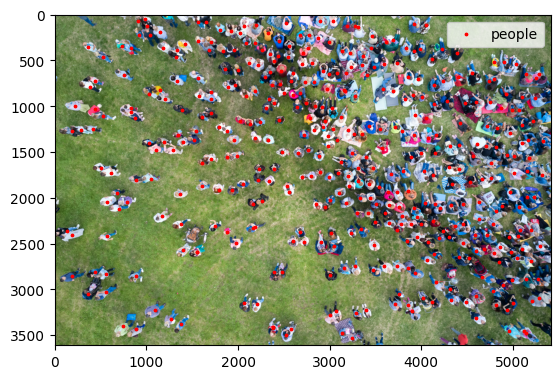

Object count: 429


In [ ]:
# Get separate x- and y-coordinate lists
x_coords, y_coords = zip(*obj_coord_list)

# Show image with annotations
plt.imshow(img)
plt.scatter(x_coords, y_coords, color='red', s=3, label=obj_name)  # Customize color and size
plt.legend()
# plt.axis('off')  # Turn off axis
plt.show()

print(f'Object count: {true_count}')

**4. Tile the image, and output number of objects in each tile and distribution proposal**

tiles = [['tiles0', 0], ['tiles1', 0], ['tiles2', 0], ['tiles3', 6], ['tiles4', 0], ['tiles5', 4], ['tiles6', 4], ['tiles7', 2], ['tiles8', 3], ['tiles9', 4], ['tiles10', 3], ['tiles11', 2], ['tiles12', 2], ['tiles13', 2], ['tiles14', 0], ['tiles15', 0], ['tiles16', 0], ['tiles17', 0], ['tiles18', 0], ['tiles19', 0], ['tiles20', 2], ['tiles21', 2], ['tiles22', 1], ['tiles23', 3], ['tiles24', 1], ['tiles25', 4], ['tiles26', 6], ['tiles27', 3], ['tiles28', 4], ['tiles29', 3], ['tiles30', 5], ['tiles31', 2], ['tiles32', 3], ['tiles33', 2], ['tiles34', 1], ['tiles35', 2], ['tiles36', 0], ['tiles37', 0], ['tiles38', 0], ['tiles39', 2], ['tiles40', 1], ['tiles41', 2], ['tiles42', 1], ['tiles43', 3], ['tiles44', 4], ['tiles45', 4], ['tiles46', 7], ['tiles47', 5], ['tiles48', 5], ['tiles49', 2], ['tiles50', 2], ['tiles51', 4], ['tiles52', 2], ['tiles53', 3], ['tiles54', 1], ['tiles55', 4], ['tiles56', 0], ['tiles57', 1], ['tiles58', 2], ['tiles59', 3], ['tiles60', 1], ['tiles61', 1], ['tiles62

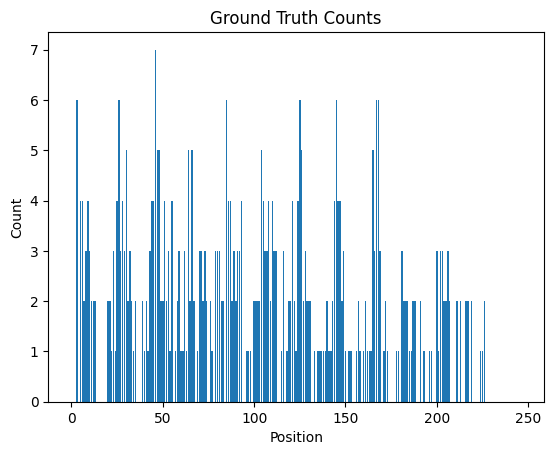

429


In [ ]:
tiles = [] # [tile_number, number_of_obj][]

for i in range(tiles_per_row * tiles_per_col):
    tiles.append([f'tiles{i}', 0]) # set up tiles with initial number of 0

for obj in obj_coord_list:
  x, y = obj
  tiles[int(x // tile_size + (y // tile_size) * tiles_per_row)][1] += 1

print(f'tiles = {tiles}')

count_arr = []

for tile in tiles:
  count_arr.append(tile[1])

# Plot the actual counts as a bar chart
plt.title('Ground Truth Counts')
plt.ylabel('Count')
plt.xlabel('Position')
plt.bar(np.arange(len(count_arr)), count_arr)
plt.show()
print(np.sum(count_arr))

**Notes**

Step 1: make data np.array

Step 2: make q_uniform

Step 3: call run_importance_sampling using 1 and 2 --> do this 187 times (n=1 to 187)

Step 4: plot values from step 3


**5. Import the normalized counts (from the computer vision model)**

In [ ]:
np.set_printoptions(threshold=50)

sum = np.sum(q_probs) # total predicted count by the model

q_probs_count = []

q_probs_prob = []

npy_tile_size = 0 # TODO: calculate new tile size based on the npy file (propotional to the original image's tile size)

for y in range(0, np.shape(q_probs)[0], 87):
  for x in range(0, np.shape(q_probs)[1], 87):
    tile = np.sum(q_probs[y:y + 87, x:x + 87])
    q_probs_count.append(tile)

q_probs_count = np.array(q_probs_count)
q_probs_prob = q_probs_count/np.sum(q_probs_count)

print(q_probs_count) # list of count of each tile

print(q_probs_prob) # list of probabilities of each tile

print(np.sum(q_probs_prob)) # make sure that total probability is 1.0


[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
443.23215
443.2322
247
[0.11142263 0.57567984 0.60324866 ... 0.         0.         0.        ]
[0.00025139 0.00129882 0.00136102 ... 0.         0.         0.        ]
1.0


**5a. Implement Importance Sampling**

In [ ]:
# Pick a random sample of size n according to q_probs
sample_indices = np.random.choice(np.arange(len(q_probs_prob)), size=100, p=q_probs_prob)
samples = q_probs_count[sample_indices]

print(samples)

[4.384035  5.600076  3.3975203 ... 3.2054954 2.3979712 2.9640665]


**5b. Implement Uniform Sampling**

In [ ]:
uniform_data = np.array([true_count/tiles_count]).repeat(tiles_count)

uniform_probs = np.ones_like(uniform_data)/tiles_count

[1.73684211 1.73684211 1.73684211 ... 1.73684211 1.73684211 1.73684211]
[0.00404858 0.00404858 0.00404858 ... 0.00404858 0.00404858 0.00404858]
0.9999999999999997


**5c. Implement Triangle Sampling**

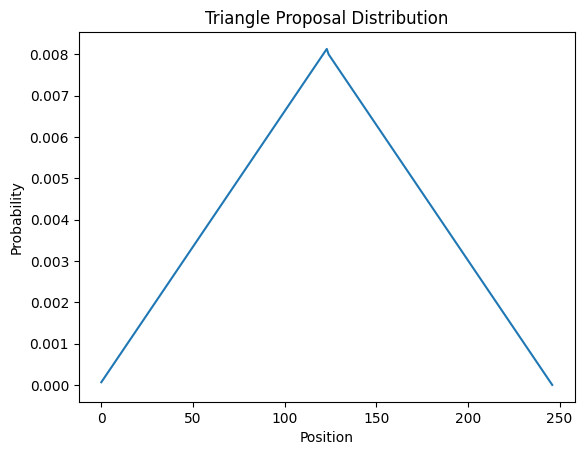

In [ ]:
# Triangle sampling distribution, increases linearly and then decreases linearly
# x will be a numy array of integers between 0 and NUMCOUNT
# If x is between  0 and NUMCOUNT//2 we want to return x+1 (increase linearly)
# Otherwise, we want to return NUMCOUNT - x (decrease linearly)
def q_triangle(count_arr):
  arr = np.asarray(count_arr)

  # N is the maximum value in arr (assumes arr == [0, 1 ,… , N])
  N = len(arr) - 1
  half = N // 2

  # raw triangular weights: rising then falling
  weights = np.where(
        arr <= half,
        arr + 1,      # from 0 up to half: weight = x+1
        N - arr       # after half:        weight = N−x
    )

  # normalize to get probabilities
  return weights / weights.sum()

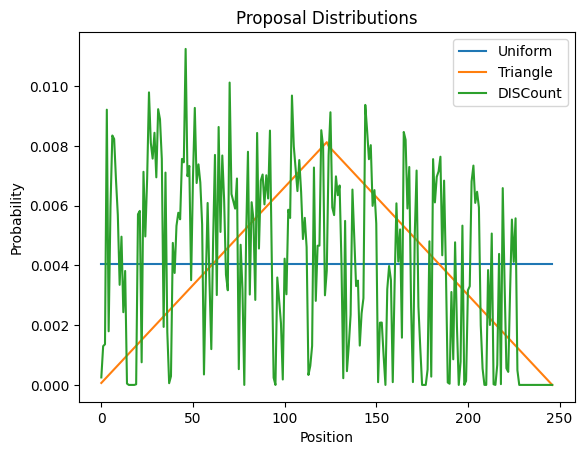

In [ ]:
# Show the uniform, triangle and normal distribution all together
plt.title('Proposal Distributions')
plt.ylabel('Probability')
plt.xlabel('Position')
plt.plot(uniform_probs)
plt.plot(q_triangle(np.arange(len(count_arr))))
plt.plot(q_probs_prob)
plt.legend(['Uniform', 'Triangle', 'DISCount'])
plt.show()

**6. Sample the distributions to compare with the ground truth**

In [ ]:
# Performs importance sampling and returns the mean and variance of each estimate
# data is the array of counts whose mean we want to estimate
# q_dist is the sampling distribution
# n is the maximum number of samples to estimate the mean with
NUM_COUNT = 247
def run_importance_sampling(data, q_probs, n=NUM_COUNT):
  n+=1

  # Compute the probability of sampling each count in data based on q_dist
  #q_probs = q_probs/np.sum(q_probs) # Ensure probabilities sum to 1

  # Pick a random sample of size n according to q_probs
  sample_indices = np.random.choice(np.arange(len(data)), size=n, p=q_probs)
  samples = data[sample_indices]

  # Calculate the weight p/q to adjust for some counts being more or less likely
  weights = (1/(q_probs[sample_indices]*len(data)))

  # Compute the mean and variance of the first k samples for all k from 1 to n
  mean_estimates = np.cumsum(samples*weights)/np.arange(1, n+1)
  var_estimates = (np.cumsum((samples*weights)**2)/np.arange(1, n+1) - mean_estimates**2)[1:]/np.arange(1, n)

  # Multiply by the number of counts to get an estimate for the total count
  return mean_estimates[1:]*len(data), var_estimates*(len(data)**2)

# Estimate the total count with uniform sampling and normal sampling
mean_estimates_uniform, var_estimates_uniform = run_importance_sampling(np.array(count_arr), uniform_probs)
mean_estimates_normal, var_estimates_normal = run_importance_sampling(np.array(count_arr), q_probs_prob)
mean_estimates_triangle, var_estimates_triangle = run_importance_sampling(np.array(count_arr), q_triangle(q_probs_count))

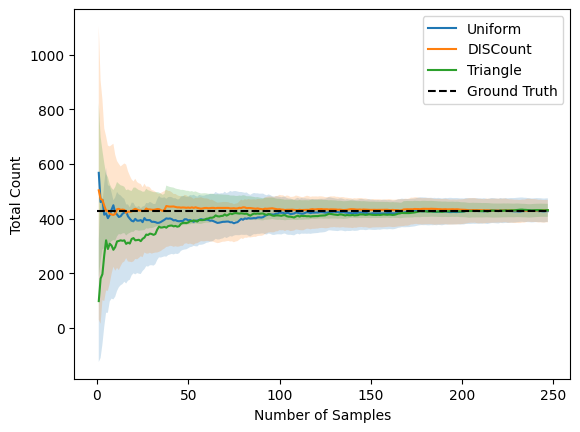

In [ ]:
############# JUST COMMENT OUT THE BELOW TO MAKE IT ONE RUN #############################

# Will add the simulations and take the means of 100 simulations for normal estimate
runs = 5

mean_sum_normal_crowd = np.zeros(NUM_COUNT, dtype=float)
var_sum_normal_crowd  = np.zeros(NUM_COUNT, dtype=float)

for _ in range(runs):
    mean_estimates_normal, var_estimates_normal = run_importance_sampling(np.array(count_arr),q_probs_prob)
    mean_sum_normal_crowd += mean_estimates_normal
    var_sum_normal_crowd  += var_estimates_normal

mean_estimates_normal_crowd = mean_sum_normal_crowd / runs
var_estimates_normal_crowd  = var_sum_normal_crowd  / runs

# Will add the simulations and take the means of 100 simulations for uniform estimate

mean_sum_uniform_crowd = np.zeros(NUM_COUNT, dtype=float)
var_sum_uniform_crowd  = np.zeros(NUM_COUNT, dtype=float)

for _ in range(runs):
    mean_estimates_uniform, var_estimates_uniform = run_importance_sampling(np.array(count_arr), uniform_probs)
    mean_sum_uniform_crowd += mean_estimates_uniform
    var_sum_uniform_crowd  += var_estimates_uniform

mean_estimates_uniform_crowd = mean_sum_uniform_crowd / runs
var_estimates_uniform_crowd  = var_sum_uniform_crowd  / runs


mean_sum_triangle_crowd = np.zeros(NUM_COUNT, dtype=float)
var_sum_triangle_crowd  = np.zeros(NUM_COUNT, dtype=float)

for _ in range(runs):
    mean_estimates_triangle, var_estimates_triangle = run_importance_sampling(np.array(count_arr), uniform_probs)
    mean_sum_triangle_crowd += mean_estimates_triangle
    var_sum_triangle_crowd  += var_estimates_triangle

mean_estimates_triangle_crowd = mean_sum_triangle_crowd / runs
var_estimates_triangle_crowd  = var_sum_triangle_crowd  / runs


############# JUST COMMENT OUT THE ABOVE TO MAKE IT ONE RUN #############################


# Plot the estimates as a function of samples
xs = np.arange(1,len(mean_estimates_uniform_crowd)+1)
plt.plot(xs, mean_estimates_uniform_crowd, label='Uniform')
plt.fill_between(xs, mean_estimates_triangle_crowd-1.645*(var_estimates_triangle_crowd**0.5), mean_estimates_triangle_crowd+1.645*(var_estimates_triangle_crowd**0.5), alpha=0.2)
plt.plot(xs, mean_estimates_normal_crowd, label='DISCount')
plt.fill_between(xs, mean_estimates_uniform_crowd-1.645*(var_estimates_uniform_crowd**0.5), mean_estimates_uniform_crowd+1.645*(var_estimates_uniform_crowd**0.5), alpha=0.2)
plt.plot(xs, mean_estimates_triangle_crowd, label='Triangle')
plt.fill_between(xs, mean_estimates_normal_crowd-1.645*(var_estimates_normal_crowd**0.5), mean_estimates_normal_crowd+1.645*(var_estimates_normal_crowd**0.5), alpha=0.2)
plt.hlines(true_count, 0, len(mean_estimates_normal_crowd), linestyles='--', label='Ground Truth', color='black')
plt.ylabel('Total Count')
plt.xlabel('Number of Samples')
plt.legend()
plt.show()